In [1]:
import random
import PIL
import os
import cv2
from PIL import Image
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_dilation, binary_erosion
import torch
import torchvision
from torchvision import transforms

In [3]:
import sys
sys.path.append('..')
from src.efficientunet import *
from src.dataset import  RetinalDataset
from src.model import get_torchvision_model
import src.segmentation_models_pytorch as smp

# Transformation
from src.transformation import train_transformation, inference_transformation
# FAZ Preprocessing
from src.dataset import FAZ_Preprocess
# Level Set
from src.levelset import *
# Metrics
from src.metrics import scoring
# Handy ultility function
from src.utils import binarize_phi

# CONSTANTS
SCALE = 256

## Load model

**NOTE**: Make sure datasets and models have been setup properly by running `../setup_model_data.sh`

In [2]:
model = get_torchvision_model("Se_resnext50", True, 1, "focal")

In [3]:
state_dict = torch.load("models/Se_resnext50-920eef84.pth",  map_location=torch.device('cpu'))
state_dict = state_dict["state"]
model.load_state_dict(state_dict)

<All keys matched successfully>

## Predict and Visualization: step by step

### Load image

(<matplotlib.axes._subplots.AxesSubplot at 0x169e2f6d8>,
 Text(0.5, 1.0, 'Ground truth mask'),
 (-0.5, 303.5, 303.5, -0.5))

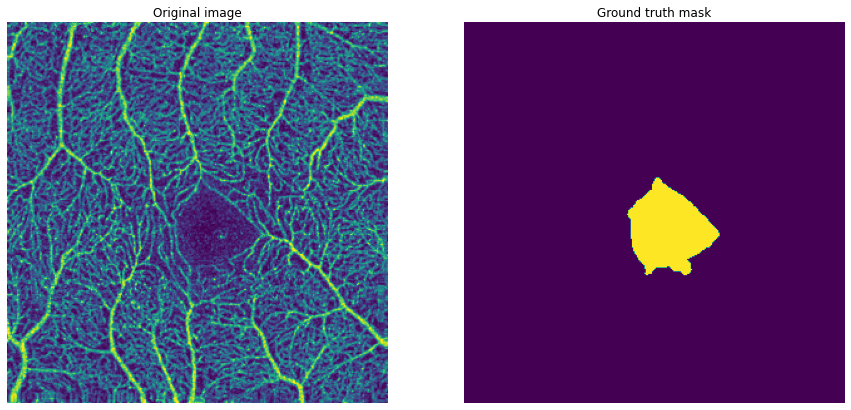

In [26]:
# Load image
imagename = 'JC_11100_Angio Retina_OD_2016-04-01_16-28-24_Enface-304x304' 
impath = 'images/samples/raw/' + imagename + '.tif'
im = plt.imread(impath)

labelpath = 'images/samples/mask/' + imagename + '.png'
label = plt.imread(labelpath)

plt.figure(figsize=(15,10)), plt.axis('off')
plt.subplot(1,2,1), plt.imshow(im), plt.title('Original image'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(label), plt.title('Ground truth mask'), plt.axis('off')

### Enhanced by Hessian-based filter

In [27]:
# Loading image and ENHANCE by Hessian-based filter
enhanced = FAZ_Preprocess(impath,[0.5,1, 1.5, 2, 2.5],1, 2).vesselness2d()

(<matplotlib.image.AxesImage at 0x167f53278>,
 (-0.5, 303.5, 303.5, -0.5),
 Text(0.5, 1.0, 'Enhanced by Hessian filter'))

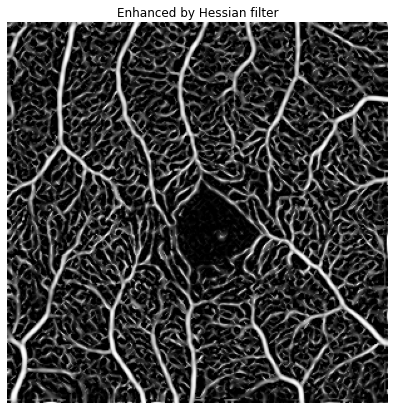

In [28]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced, cmap='gray'), plt.axis('off'), plt.title('Enhanced by Hessian filter')

### Segment (predict) using DNN

In [29]:
# Transformation (to tensor)
tensor_transform = transforms.Compose([
    transforms.Resize((SCALE, SCALE)),
    transforms.ToTensor()
])

enhanced_ts = tensor_transform(Image.fromarray(enhanced.astype(np.float32)*255).convert("RGB"))

enhanced_ts.shape

torch.Size([3, 256, 256])

In [30]:
model.eval()
mask = enhanced_ts.unsqueeze(0)
mask = model(mask)
mask = (mask.to("cpu").detach().numpy() > 0.6) * 1
mask = mask.reshape((SCALE, SCALE))

((-0.5, 255.5, 255.5, -0.5), Text(0.5, 1.0, 'Mask predicted by UNet'))

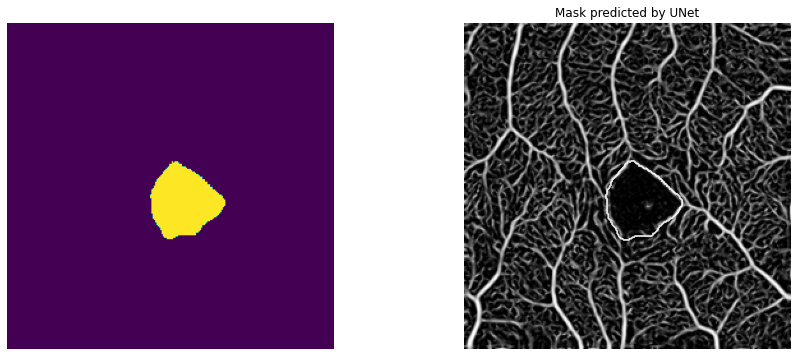

In [31]:
plt.figure(figsize=(15,6))

# Show generated mask
plt.subplot(1,2,1)
plt.imshow(mask), plt.axis('off')

# Show mask overlapping image
enhanced_scaled = enhanced_ts.permute(1,2,0).numpy()
enhanced_scaled =  cv2.cvtColor(enhanced_scaled, cv2.COLOR_RGB2GRAY)

plt.subplot(1,2,2)
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(mask, cmap='gray', alpha=0.3)
plt.contour(mask, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet')

In [32]:
# Measure performance of the current step
label_PIL = Image.fromarray(label.astype(np.float32)*255).convert("RGB")
label_ts = tensor_transform(label_PIL) # convert label to the same size with mask, equal to `size` defined above
scoring(label_ts.to("cpu").numpy(), mask)

(0.87, -1.96, 0.06)

### LEVEL SET

In [33]:
phi, delta = levelset(enhanced_ts, mask, 10, isplot=False)


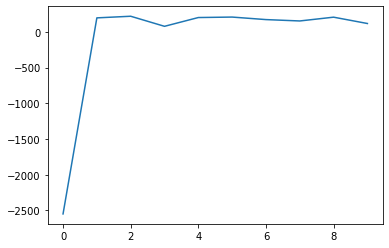

In [34]:
plt.plot(delta)

(<matplotlib.image.AxesImage at 0x168908a20>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little, after LEVELSET'))

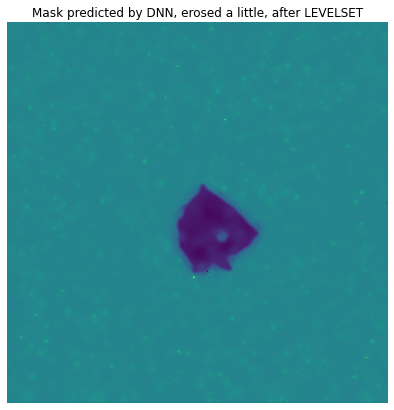

In [35]:
plt.figure(figsize=(13,7))
plt.imshow(phi), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little, after LEVELSET')

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

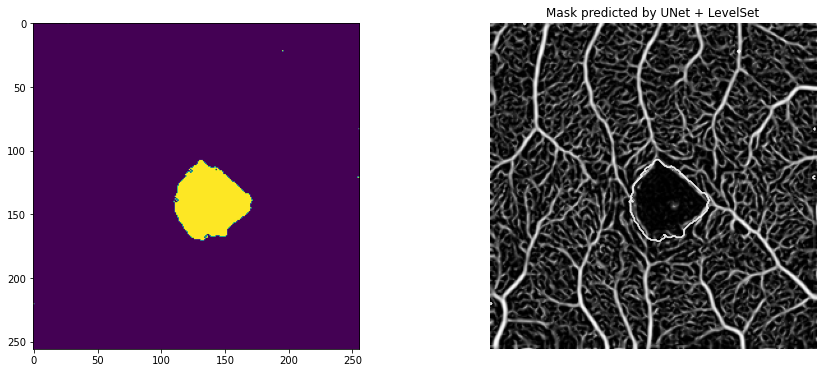

In [36]:
plt.figure(figsize=(15,6))
# Show phi
binary_phi = binarize_phi(phi)
plt.subplot(1,2,1)
plt.imshow(binary_phi)

# Show phi overlapping image
plt.subplot(1,2,2)
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

In [37]:
# Measure performance of the current step
scoring(label_ts.to("cpu").numpy(), binary_phi)

(0.9, -1.91, 0.02)

In [38]:
# EROSE the output mask
kernel1 = np.array([
        [0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0]])   
kernel2 = np.ones((5,5))

erosed_phi = binary_erosion(binary_phi.copy(), kernel1, iterations = 1)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

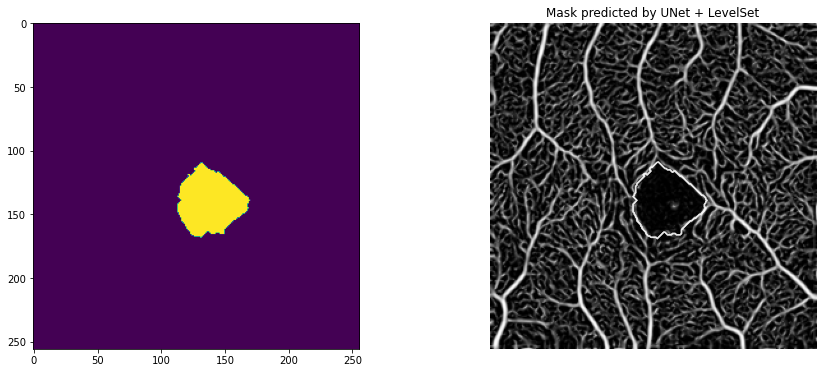

In [39]:
plt.figure(figsize=(15,6))
# Show phi
plt.subplot(1,2,1)
plt.imshow(erosed_phi)

# Show phi overlapping image
plt.subplot(1,2,2)
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(erosed_phi, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

In [40]:
# Measure performance of the current step
scoring(label_ts.to("cpu").numpy(), erosed_phi)

(0.81, -1.98, 0.13)

### Erosion + Levelset

In [41]:
# EROSE the output mask
kernel1 = np.array([[0, 0, 1, 0, 0],
           [0, 1, 1, 1, 0],
           [1, 1, 1, 1, 1],
           [0, 1, 1, 1, 0],
           [0, 0, 1, 0, 0]])   
kernel2 = np.ones((5,5))

erosed_mask = binary_erosion(mask.copy(), kernel2, iterations = 3)

(<matplotlib.image.AxesImage at 0x16792bc88>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little'))

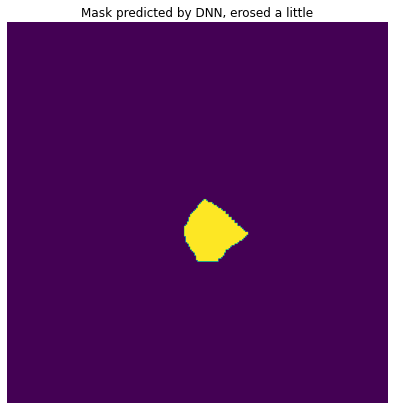

In [42]:
plt.figure(figsize=(13,7))
plt.imshow(erosed_mask), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little')

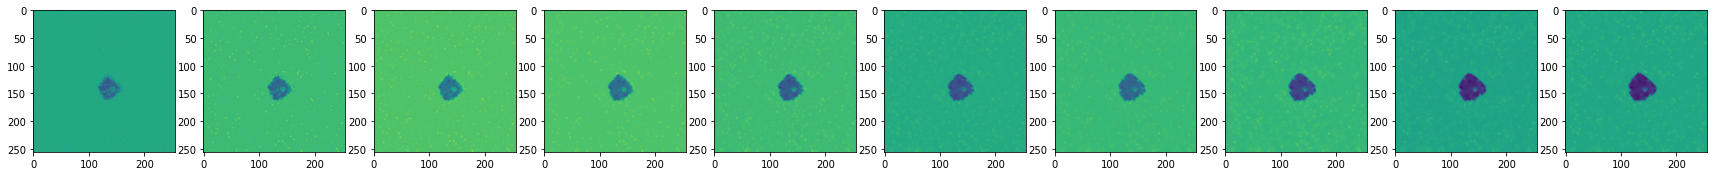

In [43]:
phi2, delta = levelset(enhanced_ts, erosed_mask, 10, isplot=True)

In [44]:
binary_phi2 = binarize_phi(phi2)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

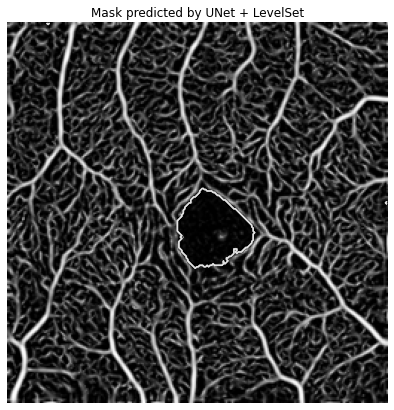

In [45]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi2, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

In [46]:
# Measure performance of the current step
scoring(label_ts.to("cpu").numpy(), binary_phi2)

(0.67, -2.0, 0.28)